In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
#from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr
import os
from keras.models import load_model
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import SimpleRNN
from keras.layers import GRU

from utils import Minmaxscaler
########################
n_steps_in=72
n_steps_out=24
dataset_dir='data'
########################

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)# modify the default parameters of np.load
data = {}
for category in ['train', 'val', 'test']:
    cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
    data['x_' + category] = cat_data['x']
    data['y_' + category] = cat_data['y']
np.load = np_load_old# restore np.load for future normal usage

scaler = Minmaxscaler(minvalue=np.min(data['x_train'],axis=(0,1)), maxvalue=np.max(data['x_train'],axis=(0,1)))
for category in ['train', 'val', 'test']:
    #data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
    #data['y_' + category][..., 0] = scaler.transform(data['y_' + category][..., 0])
    data['x_' + category] = scaler.transform(data['x_' + category])#[...,idx]
    data['y_' + category] = scaler.transform(data['y_' + category])[:,:,:1]
for cat in ["train", "val", "test"]: print(data['x_'+cat].shape,data['y_'+cat].shape)
for cat in ["train", "val", "test"]: print(cat,np.min(data['x_'+cat]),np.max(data['x_'+cat]),np.min(data['y_'+cat]),np.max(data['y_'+cat]))

model=[]
pred=[]
nr=11
for i in range(nr):
    n_features_w=i+1#10#1,...,11
    idx=[9,5,11,3,10,4,1,2,8,6, 7]#[8,4,10,3,9,11,1,2,7,5,6]
    idx=np.array(idx[:n_features_w])
    idx=np.concatenate([[0],idx*2-1,idx*2],axis=0)
    idx=np.setdiff1d(idx,[12,14,16,18,20,22])
    idx=np.sort(idx)
    print(idx)
    n_features=len(idx)
    #model.append(load_model('saved_model/worelu_all_forecasting/'+str(i+1)+'/final.h5'))
    model.append(load_model('saved_model/wrelu_five_forecasting/'+str(i+1)+'/final.h5'))
    #model.append(load_model('saved_model/worelu_five_forecasting/'+str(i+1)+'/final.h5'))
    pred1= model[i].predict(data['x_test'][...,idx])
    pred1 = scaler.inverse_transform(pred1)
    pred.append(pred1)
pred=np.array(pred)

actual=scaler.inverse_transform(data['y_test'])

Using TensorFlow backend.


(15767, 72, 23) (15767, 24, 1)
(5256, 72, 23) (5256, 24, 1)
(5256, 72, 23) (5256, 24, 1)
train 0.0 1.0 0.0 1.0
val -0.08192771084337354 1.0 0.0 0.9872337211059072
test -0.3870192307692311 1.0571428571428572 0.0 0.9261217706602206
[ 0 17]
[ 0  9 10 17]
[ 0  9 10 17 21]
[ 0  5  6  9 10 17 21]
[ 0  5  6  9 10 17 19 21]
[ 0  5  6  7  8  9 10 17 19 21]
[ 0  1  2  5  6  7  8  9 10 17 19 21]
[ 0  1  2  3  4  5  6  7  8  9 10 17 19 21]
[ 0  1  2  3  4  5  6  7  8  9 10 15 17 19 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 15 17 19 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 15 17 19 21]


In [2]:
#w relu - 5 forecasting values
for i in range(nr):
    print(i,'==========')
    rmse=np.sqrt(mean_squared_error(actual.flatten(),pred[i].flatten()))
    print('rmse: %.3f'%rmse)
    print('rmse/max',rmse/np.max(actual)*100)
    print('rmse/mean',rmse/np.mean(actual)*100)
    print('rmse/std',rmse/np.std(actual)*100)
    print('rmse/IQR',rmse/iqr(actual)*100)
    wape=np.mean(np.abs((actual - pred)/np.mean(actual))) * 100
    print('WAPE: ',wape)
    print('mae',np.mean(np.abs(actual-pred)))

nrmse_max=[]
for i in range(nr):
    rmse=np.sqrt(mean_squared_error(actual.flatten(),pred[i].flatten()))
    nrmse=rmse/np.max(actual)
    print('rmse/max',nrmse)
    nrmse_max.append(nrmse)

0 ==========
rmse: 125400.169
rmse/max 14.20610936649633
rmse/mean 89.01090729726276
rmse/std 55.167928118009655
rmse/IQR 58.28878876614625
WAPE:  42.58811272655805
mae 59998.899892433685
1 ==========
rmse: 107960.897
rmse/max 12.23048042668743
rmse/mean 76.63225246092526
rmse/std 47.495781400887935
rmse/IQR 50.18262718580585
WAPE:  42.58811272655805
mae 59998.899892433685
2 ==========
rmse: 114098.184
rmse/max 12.925750420035767
rmse/mean 80.98859038061286
rmse/std 50.195789124755684
rmse/IQR 53.0353748827438
WAPE:  42.58811272655805
mae 59998.899892433685
3 ==========
rmse: 108359.144
rmse/max 12.27559636585098
rmse/mean 76.91493440957944
rmse/std 47.67098439451131
rmse/IQR 50.36774144756794
WAPE:  42.58811272655805
mae 59998.899892433685
4 ==========
rmse: 113319.317
rmse/max 12.837515553155828
rmse/mean 80.4357391140473
rmse/std 49.85313832093923
rmse/IQR 52.67334025491649
WAPE:  42.58811272655805
mae 59998.899892433685
5 ==========
rmse: 114414.986
rmse/max 12.961639759075826
rmse

C:\Users\user02\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\user02\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\user02\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous ax

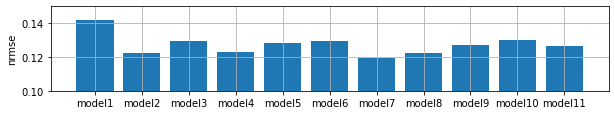

In [7]:
fig=plt.figure(figsize=(10,9))
#for i in range(5):
fig.add_subplot(5,1,1).bar(["model"+str(i+1) for i in range(11)],nrmse_max)
#fig.add_subplot(5,1,1).set_title('wape')
fig.add_subplot(5,1,1).set_ylabel("nrmse")
fig.add_subplot(5,1,1).grid()
fig.add_subplot(5,1,1).set_ylim(0.1,0.15)
plt.show()

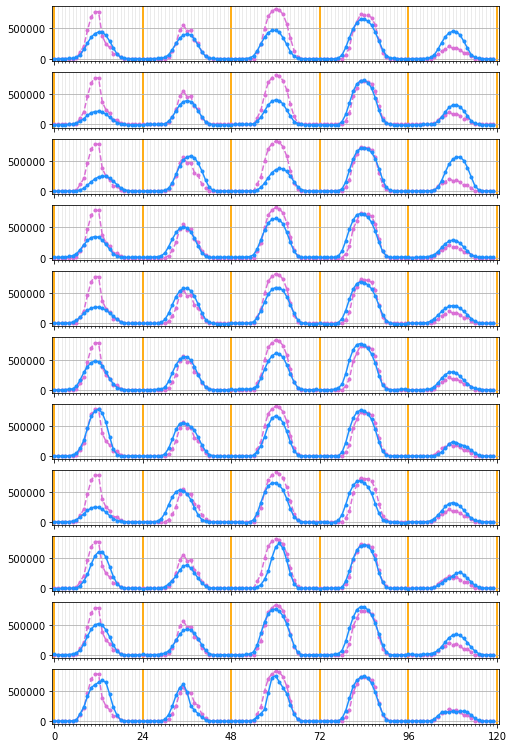

In [36]:
y_t=scaler.inverse_transform(data['y_test'])
y_t=y_t[np.arange(0,len(data['y_test']),24)]

fig = plt.figure(figsize=(8,1.2*nr))                                                               
#ax = fig.add_subplot(1,1,1)                                                      
for i in range(nr):#[6]:#
    
    predi=pred[i][np.arange(0,len(data['y_test']),24)]#w
    j=100
    predi=predi[j:j+5].flatten()#predi=pred[i][-24*5:]
    actuali=y_t[j:j+5].flatten()
    
    ax = fig.add_subplot(nr,1,i+1)                                
    major_ticks = np.arange(0, len(predi)+1, 24)                                              
    minor_ticks = np.arange(0, len(predi)+1, 1)                                               
    plt.plot(actuali,marker='.',ls='--',c='orchid', label = 'Real')
    ax.plot(predi, marker='.',ls='-',c='dodgerblue', label = 'Pred') 
    #ax.legend()
    #ax.set_title('model'+str(i+1))
    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')                                                                                           
    ax.grid(which='minor', alpha=0.3)                                                
    ax.grid(which='major', alpha=1.0,linewidth=1.8,color='orange',axis='x')
    if i!=nr-1: ax.xaxis.set_ticklabels([])
    ax.set_xlim([-0.5, 120.5])
#plt.savefig('result.png')
plt.show()

In [2]:
#wo relu - 5 forecasting values

0 ==========
rmse: 123399.417
rmse/max 13.979451770352536
rmse/mean 87.59074377760436
rmse/std 54.28772723760875
rmse/IQR 57.358794747162676
WAPE:  42.82094183507841
mae 60326.913731976085
1 ==========
rmse: 105371.005
rmse/max 11.937081400304383
rmse/mean 74.79390862837109
rmse/std 46.3563972120285
rmse/IQR 48.978787807139135
WAPE:  42.82094183507841
mae 60326.913731976085
2 ==========
rmse: 105526.380
rmse/max 11.954683237031736
rmse/mean 74.90419606997666
rmse/std 46.42475208937512
rmse/IQR 49.05100953347025
WAPE:  42.82094183507841
mae 60326.913731976085
3 ==========
rmse: 109710.332
rmse/max 12.428667266970965
rmse/mean 77.87402739119709
rmse/std 48.26541910229006
rmse/IQR 50.99580344480054
WAPE:  42.82094183507841
mae 60326.913731976085
4 ==========
rmse: 111553.489
rmse/max 12.637471586727166
rmse/mean 79.18232802929582
rmse/std 49.07628866593057
rmse/IQR 51.8525440606677
WAPE:  42.82094183507841
mae 60326.913731976085
5 ==========
rmse: 109730.256
rmse/max 12.430924459142762
rm

In [2]:
#wo relu - all foreasting

0 ==========
rmse: 84888.070
rmse/max 9.616647404636012
rmse/mean 60.25481633016822
rmse/std 37.345236409794666
rmse/IQR 39.45786384900854
WAPE:  31.936815895074606
mae 44993.16116857879
1 ==========
rmse: 86872.069
rmse/max 9.841407092438583
rmse/mean 61.663088167237035
rmse/std 38.21806696322975
rmse/IQR 40.38007060016634
WAPE:  31.936815895074606
mae 44993.16116857879
2 ==========
rmse: 90301.313
rmse/max 10.229893138979254
rmse/mean 64.0972166525818
rmse/std 39.726711570806174
rmse/IQR 41.97405953275959
WAPE:  31.936815895074606
mae 44993.16116857879
3 ==========
rmse: 89653.136
rmse/max 10.156463646757732
rmse/mean 63.63713109668502
rmse/std 39.441555878694395
rmse/IQR 41.67277252652269
WAPE:  31.936815895074606
mae 44993.16116857879
4 ==========
rmse: 95672.996
rmse/max 10.838430788795785
rmse/mean 67.91011763323029
rmse/std 42.089903381884056
rmse/IQR 44.47093757384081
WAPE:  31.936815895074606
mae 44993.16116857879
5 ==========
rmse: 96918.102
rmse/max 10.979484140735993
rmse/m